In [48]:
import pandas as pd
from datetime import datetime

from matplotlib import pyplot
from utils import utils as utils

<Axes: >

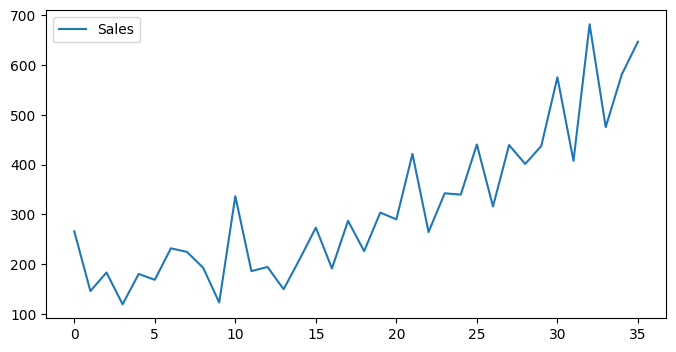

In [49]:
series = pd.read_csv("https://raw.githubusercontent.com/jbrownlee/Datasets/master/shampoo.csv")

# print(series.head())
#Convert month to Year

series["Month"] = [datetime.strptime("200" + x, '%Y-%m').date()  for x in series.Month]
series.plot()

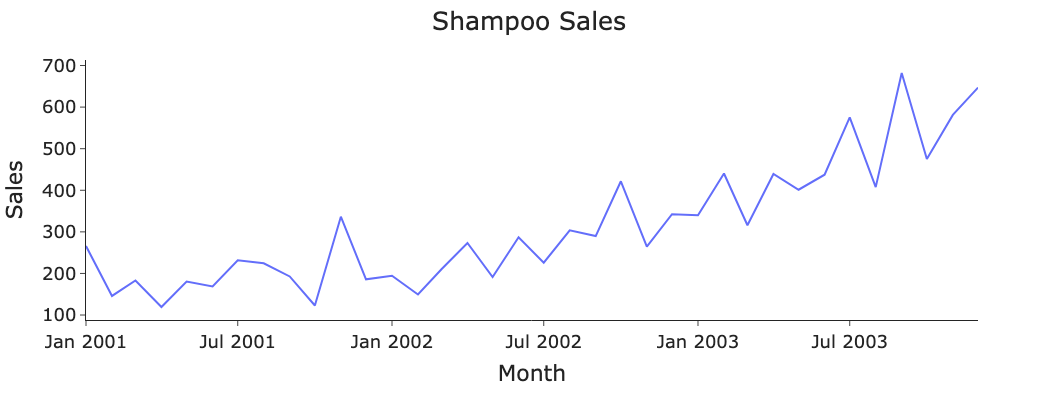

In [50]:
utils.plotting("Shampoo Sales", series, x="Month", y= "Sales", x_label="Month" , y_label="Sales")

Clearly the data is not stationary. 

ARIMA is generic

1. AR component => p
2. I : integrated => d ie order or degree of differencing needed to make it stationary
3. MA component =>(q)

e.g.

* AR(p) = ARIMA(p,0,0)
* MA(p) = ARIMA(0,0,q)

Assuming no differencing needed in the models, so putting I=0 above.


In [51]:
## Going back to above shampoo sales, seems single differencing might help

all_df = series.rename(columns={"Month":"month", "Sales":"sales"})
all_df.loc[:, "prev_sales"] = all_df.sales.shift(1)
all_df.loc[:, "diff_sales"] = all_df.loc[:, "sales"] - all_df.loc[:, "prev_sales"]
all_df.head()

,month,sales,prev_sales,diff_sales
0,2001-01-01,266.0,NaN,NaN
1,2001-02-01,145.9,266.0,-120.1
2,2001-03-01,183.1,145.9,37.2
3,2001-04-01,119.3,183.1,-63.8
4,2001-05-01,180.3,119.3,61.0


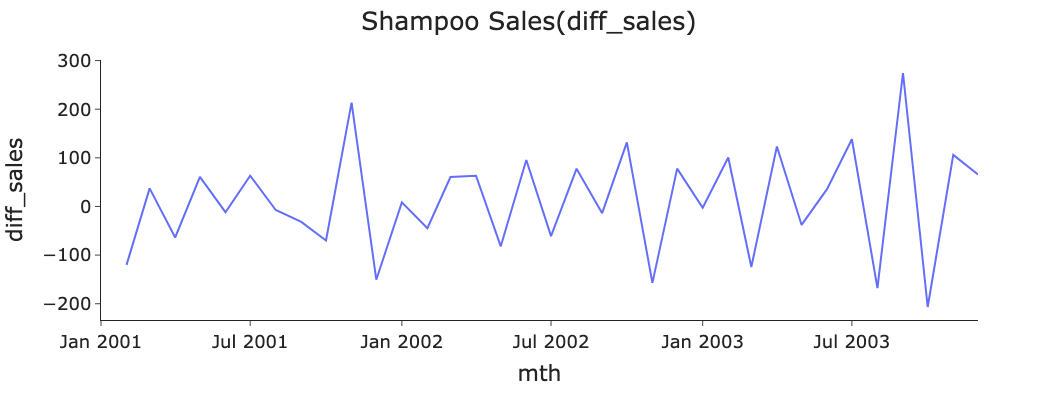

In [52]:
utils.plotting("Shampoo Sales(diff_sales)", all_df, x="month", y= "diff_sales", x_label="mth" , y_label="diff_sales")

In [56]:
all_df = all_df.dropna()
all_df.head()

,month,sales,prev_sales,diff_sales
1,2001-02-01,145.9,266.0,-120.1
2,2001-03-01,183.1,145.9,37.2
3,2001-04-01,119.3,183.1,-63.8
4,2001-05-01,180.3,119.3,61.0
5,2001-06-01,168.5,180.3,-11.8


This series looks more stationary than undifferenced one!


#### autocorrelation plot

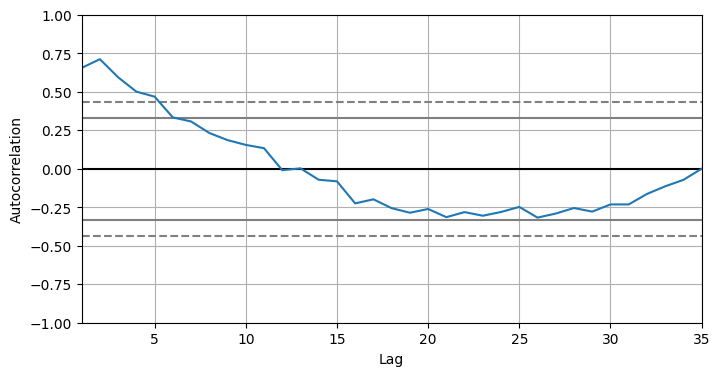

In [64]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(all_df.sales)
pyplot.show()

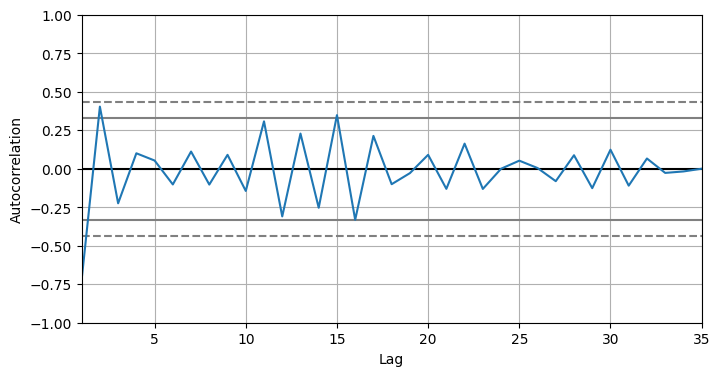

In [65]:
autocorrelation_plot(all_df.dropna().diff_sales)
pyplot.show()

In [66]:
# split test train
from utils import utils as utils
train_df, test_df  = utils.split_to_train_test(all_df, 0.66)

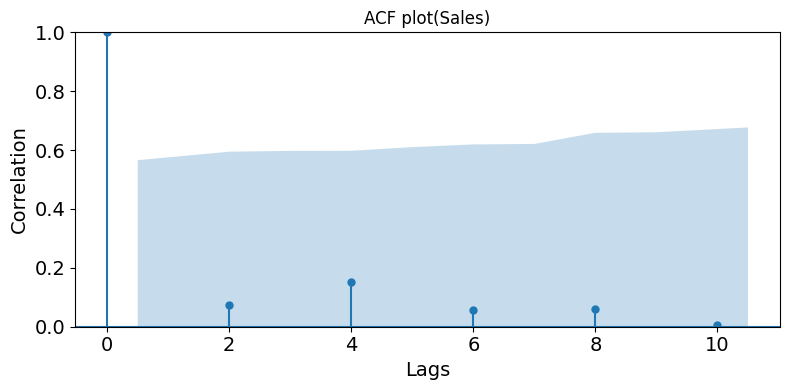

In [67]:
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

plt.rc("figure", figsize=(8,4))
plot_acf(train_df.sales, lags = 10)
plt.ylim(0,1)
plt.xlabel('Lags', fontsize = 14)
plt.ylabel('Correlation', fontsize = 14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('ACF plot(Sales)')
plt.tight_layout()
plt.show()


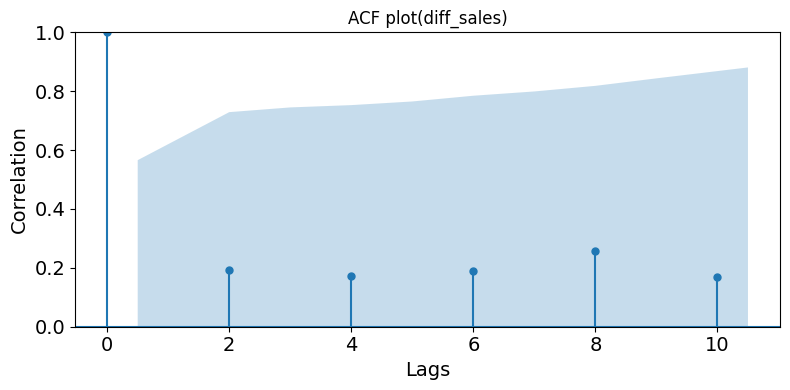

In [69]:
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

plt.rc("figure", figsize=(8,4))
plot_acf(train_df.diff_sales, lags = 10)
plt.ylim(0,1)
plt.xlabel('Lags', fontsize = 14)
plt.ylabel('Correlation', fontsize = 14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('ACF plot(diff_sales)')
plt.tight_layout()
plt.show()


In [70]:
# fit model
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(train_df.sales, order=(5,1,0))
model_fit = model.fit()
model_fit.summary()


/Users/jvsingh/anaconda3/envs/tseries/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/Users/jvsingh/anaconda3/envs/tseries/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/Users/jvsingh/anaconda3/envs/tseries/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/Users/jvsingh/anaconda3/envs/tseries/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.



<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  sales   No. Observations:                   12
Model:                 ARIMA(5, 1, 0)   Log Likelihood                 -60.203
Date:                Sun, 01 Sep 2024   AIC                            132.407
Time:                        21:09:23   BIC                            134.794
Sample:                             0   HQIC                           130.902
                                 - 12                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0391      0.888     -1.170      0.242      -2.780       0.702
ar.L2         -0.8809      1.074     -0.820      0.412      -2.987       1.225
ar.L3         -0.6142      1.846     -0.333      0.739      -4.231       3.003
ar.L4         -0.1124      1.614     -0.070      0.944      -3.277       3.052
ar.L5         -0.1418      1.390     -0.102      0.919      -2.865       2.582
sigma2      2787.1935   1610.343      1.731      0.083    -369.022    5943.409
===================================================================================
Ljung-Box (L1) (Q):                   0.78   Jarque-Bera (JB):                 0.30
Prob(Q):                              0.38   Prob(JB):                         0.86
Heteroskedasticity (H):               7.90   Skew:                             0.32
Prob(H) (two-sided):                  0.07   Kurtosis:                         2.50
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [19]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(all_df.sales, order=(3,1,0))
model_fit = model.fit()
model_fit.summary()


/Users/jvsingh/anaconda3/envs/tseries/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/Users/jvsingh/anaconda3/envs/tseries/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/Users/jvsingh/anaconda3/envs/tseries/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.



<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  sales   No. Observations:                   35
Model:                 ARIMA(3, 1, 0)   Log Likelihood                -193.976
Date:                Sun, 01 Sep 2024   AIC                            395.952
Time:                        20:12:24   BIC                            402.057
Sample:                             0   HQIC                           398.034
                                 - 35                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9148      0.236     -3.879      0.000      -1.377      -0.453
ar.L2         -0.2587      0.272     -0.953      0.341      -0.791       0.274
ar.L3          0.0297      0.173      0.172      0.863      -0.309       0.368
sigma2      5147.6677   1382.422      3.724      0.000    2438.171    7857.165
===================================================================================
Ljung-Box (L1) (Q):                   1.35   Jarque-Bera (JB):                 0.76
Prob(Q):                              0.24   Prob(JB):                         0.68
Heteroskedasticity (H):               1.73   Skew:                             0.29
Prob(H) (two-sided):                  0.38   Kurtosis:                         2.57
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [71]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(train_df.sales, order=(2,1,0))
model_fit = model.fit()
model_fit.summary()


/Users/jvsingh/anaconda3/envs/tseries/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/Users/jvsingh/anaconda3/envs/tseries/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/Users/jvsingh/anaconda3/envs/tseries/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.



<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  sales   No. Observations:                   12
Model:                 ARIMA(2, 1, 0)   Log Likelihood                 -61.278
Date:                Sun, 01 Sep 2024   AIC                            128.555
Time:                        21:09:37   BIC                            129.749
Sample:                             0   HQIC                           127.803
                                 - 12                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9060      0.452     -2.005      0.045      -1.791      -0.021
ar.L2         -0.5193      0.470     -1.104      0.270      -1.441       0.402
sigma2      3667.0452   1950.600      1.880      0.060    -156.061    7490.151
===================================================================================
Ljung-Box (L1) (Q):                   1.48   Jarque-Bera (JB):                 0.05
Prob(Q):                              0.22   Prob(JB):                         0.98
Heteroskedasticity (H):              11.35   Skew:                             0.10
Prob(H) (two-sided):                  0.04   Kurtosis:                         3.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [72]:
model_fit.aic

128.55528422749296

<Axes: xlabel='p'>

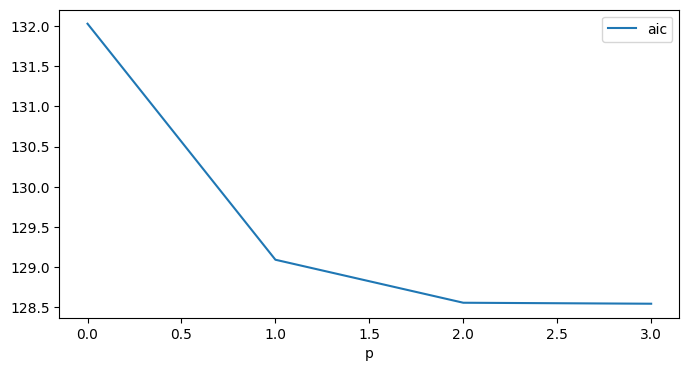

In [77]:
aic = []
ps = range(4)
for p in ps:
    model = ARIMA(train_df.sales.values, order=(p,1,0))
    model_fit = model.fit()
    model_fit.summary()
    aic.append(model_fit.aic)

pd.DataFrame({"p": ps, "aic": aic}).set_index(["p"]).plot()

In [39]:
## Min AIC comes around lag 2. so we take lag 2 model

In [78]:
model = ARIMA(train_df.sales.values, order=(2,1,0))
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   12
Model:                 ARIMA(2, 1, 0)   Log Likelihood                 -61.278
Date:                Sun, 01 Sep 2024   AIC                            128.555
Time:                        21:38:20   BIC                            129.749
Sample:                             0   HQIC                           127.803
                                 - 12                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9060      0.452     -2.005      0.045      -1.791      -0.021
ar.L2         -0.5193      0.470     -1.104      0.270      -1.441       0.402
sigma2      3667.0452   1950.600      1.880      0.060    -156.061    7490.151
===================================================================================
Ljung-Box (L1) (Q):                   1.48   Jarque-Bera (JB):                 0.05
Prob(Q):                              0.22   Prob(JB):                         0.98
Heteroskedasticity (H):              11.35   Skew:                             0.10
Prob(H) (two-sided):                  0.04   Kurtosis:                         3.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

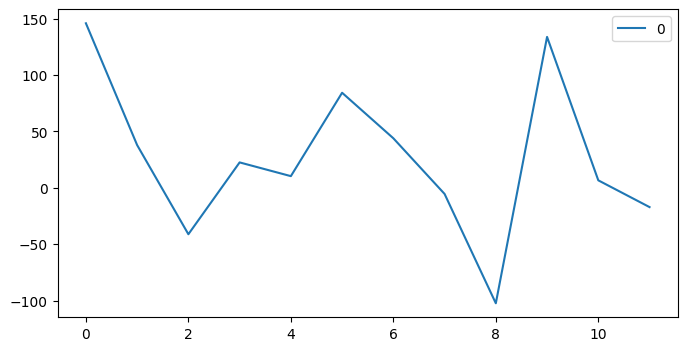

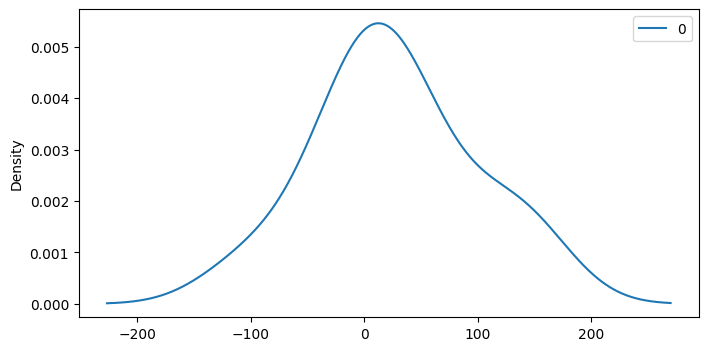

                0
count   12.000000
mean    26.591972
std     70.283925
min   -102.410038
25%     -8.362316
50%     16.425177
75%     54.011757
max    145.900000


In [79]:
# line plot of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()

# density plot of residuals
residuals.plot(kind='kde')
pyplot.show()

# summary stats of residuals
print(residuals.describe())

In [80]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   12
Model:                 ARIMA(2, 1, 0)   Log Likelihood                 -61.278
Date:                Sun, 01 Sep 2024   AIC                            128.555
Time:                        21:38:29   BIC                            129.749
Sample:                             0   HQIC                           127.803
                                 - 12                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9060      0.452     -2.005      0.045      -1.791      -0.021
ar.L2         -0.5193      0.470     -1.104      0.270      -1.441       0.402
sigma2      3667.0452   1950.600      1.880      0.060    -156.061    7490.151
===================================================================================
Ljung-Box (L1) (Q):                   1.48   Jarque-Bera (JB):                 0.05
Prob(Q):                              0.22   Prob(JB):                         0.98
Heteroskedasticity (H):              11.35   Skew:                             0.10
Prob(H) (two-sided):                  0.04   Kurtosis:                         3.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [84]:
forecasts = model_fit.forecast(test_df.shape[0])
forecasts

array([264.89386296, 196.57591316, 221.81178361, 234.42517258,
       209.89325346, 225.56853563, 224.10619708, 217.29112573,
       224.22474834, 221.48203985, 220.36634121, 222.80137335,
       221.17466885, 221.38394474, 222.03906687, 221.33687199,
       221.63284622, 221.72934009, 221.48822509, 221.65656059,
       221.62926047, 221.56657982, 221.63754314])

In [86]:
test_df.loc[:,"forecasts"] = forecasts

In [87]:
test_df

,month,sales,prev_sales,diff_sales,forecasts
13,2002-02-01,149.5,194.3,-44.8,264.893863
14,2002-03-01,210.1,149.5,60.6,196.575913
15,2002-04-01,273.3,210.1,63.2,221.811784
16,2002-05-01,191.4,273.3,-81.9,234.425173
17,2002-06-01,287.0,191.4,95.6,209.893253
18,2002-07-01,226.0,287.0,-61.0,225.568536
19,2002-08-01,303.6,226.0,77.6,224.106197
20,2002-09-01,289.9,303.6,-13.7,217.291126
21,2002-10-01,421.6,289.9,131.7,224.224748
22,2002-11-01,264.5,421.6,-157.1,221.482040
